In [2]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint

import concurrent.futures as cf
from multiprocessing import Pool
import time , functools

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
def timer(func):
    @functools.wraps(func)
    def wrapper(*args , **kwargs ):
        start = time.time()
        result = func(*args , **kwargs )
        end = time.time()

        print(f'Function runs for {end - start} s')
        return result
    return wrapper

In [4]:
# Paths for data.

Tess = "./archive/tess/TESS Toronto emotional speech set data/"
Ravdess = "./archive/ravdess/audio_speech_actors_01-24/"
Savee = "./archive/savee/AudioData/AudioData/DC/"
Crema = "./archive/crema/AudioWAV/"


sample_rate = 0

In [5]:
def read_ravdess_dataset(Ravdess = Ravdess):
    ravdess_directory_list = os.listdir(Ravdess)

    file_emotion = []
    file_path = []
    for dir in ravdess_directory_list:
        # as their are 20 different actors in our previous directory we need to extract files for each actor.
        actor = os.listdir(Ravdess + dir)
        for file in actor:
            part = file.split('.')[0]
            part = part.split('-')
            # third part in each file represents the emotion associated to that file.
            file_emotion.append(int(part[2]))
            file_path.append(Ravdess + dir + '/' + file)
            
    # dataframe for emotion of files
    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

    # dataframe for path of files.
    path_df = pd.DataFrame(file_path, columns=['Path'])
    Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

    # changing integers to actual emotions.
    Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)

    return Ravdess_df

def read_crema_dataset(Crema = Crema):
    crema_directory_list = os.listdir(Crema)

    file_emotion = []
    file_path = []

    for file in crema_directory_list:
        # storing file paths
        file_path.append(Crema + file)
        # storing file emotions
        part=file.split('_')
        if part[2] == 'SAD':
            file_emotion.append('sad')
        elif part[2] == 'ANG':
            file_emotion.append('angry')
        elif part[2] == 'DIS':
            file_emotion.append('disgust')
        elif part[2] == 'FEA':
            file_emotion.append('fear')
        elif part[2] == 'HAP':
            file_emotion.append('happy')
        elif part[2] == 'NEU':
            file_emotion.append('neutral')
        else:
            file_emotion.append('Unknown')
            
    # dataframe for emotion of files
    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

    # dataframe for path of files.
    path_df = pd.DataFrame(file_path, columns=['Path'])
    Crema_df = pd.concat([emotion_df, path_df], axis=1)
    
    return Crema_df

def read_tess_dataset(Tess = Tess):
    tess_directory_list = os.listdir(Tess)

    file_emotion = []
    file_path = []

    for dir in tess_directory_list:
        directories = os.listdir(Tess + dir)
        for file in directories:
            part = file.split('.')[0]
            part = part.split('_')[2]
            if part=='ps':
                file_emotion.append('surprise')
            else:
                file_emotion.append(part)
            file_path.append(Tess + dir + '/' + file)
            
    # dataframe for emotion of files
    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

    # dataframe for path of files.
    path_df = pd.DataFrame(file_path, columns=['Path'])
    Tess_df = pd.concat([emotion_df, path_df], axis=1)
    return Tess_df

def read_savee_dataset(Savee = Savee):
    savee_directory_list = os.listdir(Savee)

    file_emotion = []
    file_path = []

    for file in savee_directory_list:
        file_path.append(Savee + file)
        # part = file.split('_')[1]
        ele = file[0]
        if ele=='a':
            file_emotion.append('angry')
        elif ele=='d':
            file_emotion.append('disgust')
        elif ele=='f':
            file_emotion.append('fear')
        elif ele=='h':
            file_emotion.append('happy')
        elif ele=='n':
            file_emotion.append('neutral')
        elif ele=='sa':
            file_emotion.append('sad')
        else:
            file_emotion.append('surprise')
            
    # dataframe for emotion of files
    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

    # dataframe for path of files.
    path_df = pd.DataFrame(file_path, columns=['Path'])
    Savee_df = pd.concat([emotion_df, path_df], axis=1)
    return Savee_df


In [6]:
def apply_func( func ):
    # print('Here executing : ', func.__name__)
    return func()

@timer
def read_dataset():
    data_path = pd.DataFrame([])
    dataset_list = [read_ravdess_dataset , read_crema_dataset , read_tess_dataset , read_savee_dataset ]

    with cf.ThreadPoolExecutor() as executor:
        results = executor.map( apply_func , dataset_list ) 

        for result in results:
            
            data_path = pd.concat([data_path , result ],axis=0)
    return data_path

    

In [7]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate = rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps= pitch_factor)

In [8]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [159]:
def feature_extraction_base( data ):
    X , Y = [] , []

    path , emotion = data


    feature = get_features(path)
    # print(feature.shape)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
    return X , Y


In [160]:
def _feature_extraction(data_path):
    X , Y = [] , [] 
    with cf.ThreadPoolExecutor() as executor:
        results = executor.map( feature_extraction_base , zip(data_path.Path , data_path.Emotions))

        for r in results:
            # print(len(r[0][0]))
            X = X + r[0]
            Y = Y + r[1]
    
    print( len(X) , len(Y))
    return X , Y
 


In [161]:
@timer
def feature_extraction(data_path):
    global sample_rate

    # taking any example and checking for techniques.
    path = np.array(data_path.Path)[1]
    data, sample_rate = librosa.load(path)
    
    X , Y = _feature_extraction( data_path )

    return X , Y


In [182]:
def get_train_test_data(X , Y):
    # splitting data
    x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)

    return x_train , y_train , x_test , y_test

In [191]:
def one_hot_key_encode(y):
    # As this is a multiclass classification problem onehotencoding our Y.
    encoder = OneHotEncoder()
    encoded_y = encoder.fit_transform(np.array(Y_feature).reshape(-1,1)).toarray()
    return encoder , encoded_y

In [187]:
def preprocessing(x_train , x_test):
    # scaling our data with sklearn's Standard scaler
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    
    # making our data compatible to model.
    x_train = np.expand_dims(x_train, axis=2)
    x_test = np.expand_dims(x_test, axis=2)

    return x_train , x_test

In [189]:
def CNN(x_train):
    model=Sequential()
    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

    model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Dropout(0.2))

    model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

    model.add(Flatten())
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(units=8, activation='softmax'))
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

    model.summary()

    return model

In [197]:
def ReduceLR(x_train , y_train , x_test , y_test , model):
    rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
    history=model.fit(x_train, y_train, batch_size=64, epochs=200, validation_data=(x_test, y_test), callbacks=[rlrp])

    return history

In [200]:
def model_accuracy(model , history , encoder , x_test , y_test ):
    print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

    epochs = [i for i in range(200)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    test_acc = history.history['val_accuracy']
    test_loss = history.history['val_loss']

    fig.set_size_inches(20,6)
    ax[0].plot(epochs , train_loss , label = 'Training Loss')
    ax[0].plot(epochs , test_loss , label = 'Testing Loss')
    ax[0].set_title('Training & Testing Loss')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")

    ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
    ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
    ax[1].set_title('Training & Testing Accuracy')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    plt.show()

    # predicting on test data.
    pred_test = model.predict(x_test)
    y_pred = encoder.inverse_transform(pred_test)

    y_test = encoder.inverse_transform(y_test)

    df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
    df['Predicted Labels'] = y_pred.flatten()
    df['Actual Labels'] = y_test.flatten()

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = (12, 10))
    cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
    sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
    plt.title('Confusion Matrix', size=20)
    plt.xlabel('Predicted Labels', size=14)
    plt.ylabel('Actual Labels', size=14)
    plt.show()


    print(classification_report(y_test, y_pred))


In [162]:
data_path = read_dataset()
    
X , Y = feature_extraction(data_path)    
    

Function runs for 0.024997711181640625 s
35406 35406
Function runs for 1270.2320289611816 s


In [178]:
type(X) , type(Y) 

(list, list)

In [192]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('sample/features.csv', index=False)

In [193]:
X_feature = Features.iloc[: ,:-1].values
Y_feature = Features['labels'].values

Y_feature.shape

(35406,)

In [194]:

encoder , Y_feature = one_hot_key_encode(Y_feature)

x_train , y_train , x_test , y_test = get_train_test_data(X_feature , Y_feature )

x_train.shape , y_train.shape , x_test.shape , y_test.shape

((26554, 162), (26554, 8), (8852, 162), (8852, 8))

In [195]:
x_train , x_test = preprocessing(x_train,x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((26554, 162, 1), (26554, 8), (8852, 162, 1), (8852, 8))

In [196]:
model = CNN( x_train )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 162, 256)          1536      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 81, 256)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 81, 256)           327936    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 41, 256)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 41, 128)           163968    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 21, 128)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 21, 128)          

In [198]:
history = ReduceLR( x_train , y_train , x_test , y_test , model )

Epoch 1/200
415/415 [==============================] - 12s 7ms/step - loss: 1.6867 - accuracy: 0.3101 - val_loss: 1.4406 - val_accuracy: 0.4318
Epoch 2/200
415/415 [==============================] - 3s 7ms/step - loss: 1.4693 - accuracy: 0.4050 - val_loss: 1.3446 - val_accuracy: 0.4703
Epoch 3/200
415/415 [==============================] - 3s 7ms/step - loss: 1.3753 - accuracy: 0.4458 - val_loss: 1.3386 - val_accuracy: 0.4700
Epoch 4/200
415/415 [==============================] - 3s 6ms/step - loss: 1.3208 - accuracy: 0.4646 - val_loss: 1.2165 - val_accuracy: 0.5174
Epoch 5/200
415/415 [==============================] - 3s 8ms/step - loss: 1.2688 - accuracy: 0.4910 - val_loss: 1.1734 - val_accuracy: 0.5256
Epoch 6/200
415/415 [==============================] - 3s 6ms/step - loss: 1.2329 - accuracy: 0.5041 - val_loss: 1.1808 - val_accuracy: 0.5289
Epoch 7/200
415/415 [==============================] - 2s 6ms/step - loss: 1.2128 - accuracy: 0.5130 - val_loss: 1.1735 - val_accuracy: 0.538

277/277 [==============================] - 1s 3ms/step - loss: 1.9769 - accuracy: 0.6234
Accuracy of our model on test data :  62.33619451522827 %


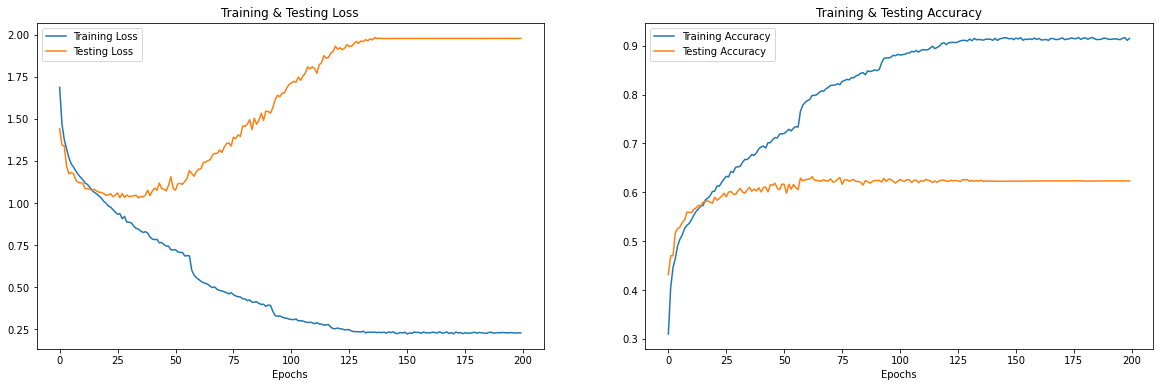

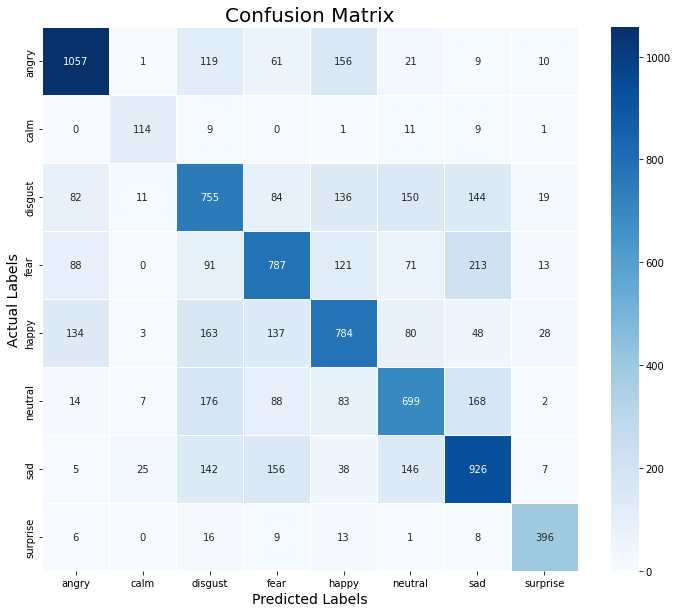

              precision    recall  f1-score   support

       angry       0.76      0.74      0.75      1434
        calm       0.71      0.79      0.75       145
     disgust       0.51      0.55      0.53      1381
        fear       0.60      0.57      0.58      1384
       happy       0.59      0.57      0.58      1377
     neutral       0.59      0.57      0.58      1237
         sad       0.61      0.64      0.62      1445
    surprise       0.83      0.88      0.86       449

    accuracy                           0.62      8852
   macro avg       0.65      0.66      0.66      8852
weighted avg       0.62      0.62      0.62      8852



In [201]:
model_accuracy(model , history , encoder , x_test , y_test )

Function runs for 0.022207021713256836 s
35406 35406
Function runs for 1270.2422149181366 s
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 162, 256)          1536      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 81, 256)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 81, 256)           327936    
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 41, 256)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 41, 128)           163968    
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 21, 128)           0         
____________________________

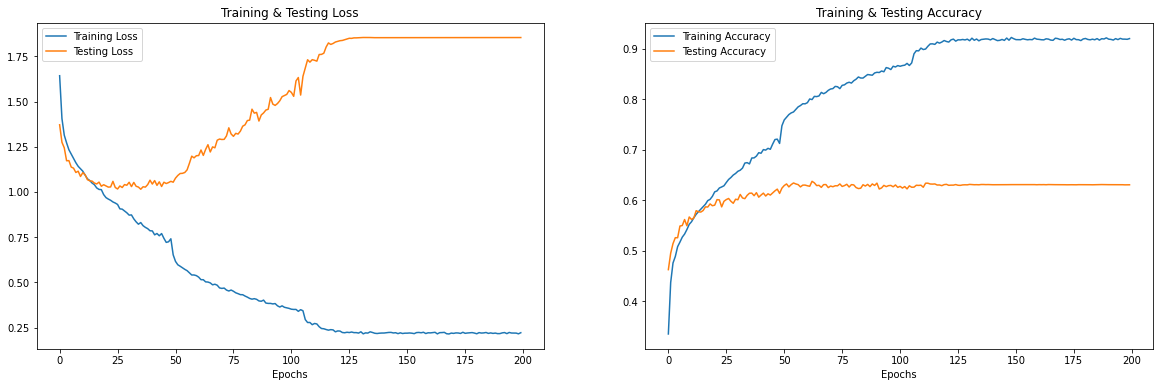

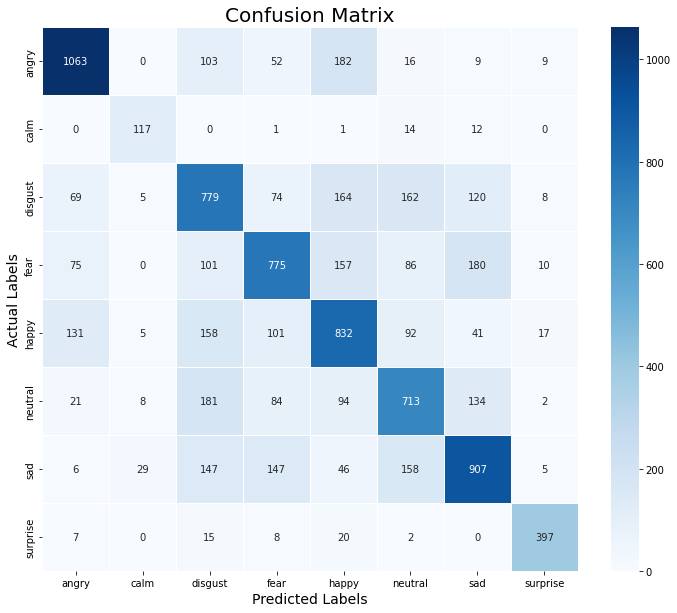

              precision    recall  f1-score   support

       angry       0.77      0.74      0.76      1434
        calm       0.71      0.81      0.76       145
     disgust       0.52      0.56      0.54      1381
        fear       0.62      0.56      0.59      1384
       happy       0.56      0.60      0.58      1377
     neutral       0.57      0.58      0.58      1237
         sad       0.65      0.63      0.64      1445
    surprise       0.89      0.88      0.89       449

    accuracy                           0.63      8852
   macro avg       0.66      0.67      0.67      8852
weighted avg       0.63      0.63      0.63      8852



In [202]:
if __name__ == '__main__':

    data_path = read_dataset()
    
    X , Y = feature_extraction(data_path) 

    Features = pd.DataFrame(X)
    Features['labels'] = Y
    Features.to_csv('sample/features.csv', index=False)   

    X_feature = Features.iloc[: ,:-1].values
    Y_feature = Features['labels'].values
    
    encoder , Y_feature = one_hot_key_encode(Y_feature)

    x_train , y_train , x_test , y_test = get_train_test_data(X_feature , Y_feature )

    x_train , x_test = preprocessing(x_train,x_test)

    model = CNN( x_train )

    history = ReduceLR( x_train , y_train , x_test , y_test , model )

    model_accuracy(model , history , encoder , x_test , y_test )

In [203]:
model.save('out/audio_sentiment.h5')